I am doing a simple regression analysis. We can later think of using Xgboost, NN's, temporal relations, forecasts, etc.

In [13]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import xgboost
import proplot as pplt
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

In [2]:
# list regions
# list excel files and transform them to parquet to read faster
files = [f for f in os.listdir("data/energy/") if f.endswith('.xlsx')]
regions = [f.split('_')[-1].split(".")[0] for f in files]
print(regions)

['MIDW', 'TEX', 'FlA', 'NE', 'SE', 'US48', 'SW', 'NY', 'MIDA', 'CAR', 'NW', 'CENT', 'CAL', 'TEN']


In [3]:
# list excel files and transform them to parquet to read faster
for region in tqdm(regions):
    src_file = "data/energy/Region_" + region + ".xlsx"
    tgt_file = "data/energy/Region_" + region + ".parquet"
    if not os.path.exists(tgt_file):
        df = pd.read_excel(src_file)
        df.to_parquet(tgt_file)

100%|██████████| 14/14 [00:00<00:00, 403.98it/s]


## 2. Example in California

In [4]:
region = "CAL"
file = f"data/energy/Region_{region}.parquet"
df = pd.read_parquet(file)
print(df.shape)
print(df.columns)

(66841, 56)
Index(['Region', 'UTC time', 'Local date', 'Hour', 'Local time', 'Time zone',
       'DF', 'D', 'NG', 'TI', 'Sum (NG)', 'NG: COL', 'NG: NG', 'NG: NUC',
       'NG: OIL', 'NG: WAT', 'NG: SUN', 'NG: WND', 'NG: OTH', 'NG: UNK',
       'Sum (Trade)', 'Sum (Imports)', 'Sum (Exports)', 'CAL', 'CAR', 'CENT',
       'FLA', 'MIDA', 'MIDW', 'NE', 'NW', 'NY', 'SE', 'SW', 'TEN', 'TEX',
       'CAN', 'MEX', 'Balance NG D TI', 'Balance TI Trade', 'Balance NG',
       'CO2 Factor: COL', 'CO2 Factor: NG', 'CO2 Factor: OIL',
       'CO2 Emissions: COL', 'CO2 Emissions: NG', 'CO2 Emissions: OIL',
       'CO2 Emissions: Other', 'CO2 Emissions Generated',
       'CO2 Emissions Imported', 'CO2 Emissions Exported',
       'CO2 Emissions Consumed', 'Positive Generation', 'Consumed Electricity',
       'CO2 Emissions Intensity for Generated Electricity',
       'CO2 Emissions Intensity for Consumed Electricity'],
      dtype='object')


In [5]:
df = df[df["NG: SUN"] > 0]
print(df.shape)

(35122, 56)


In [6]:
predictors =  ["Sum (NG)", "Sum (Trade)"]
treatment = "NG: SUN"
outcome = "NG: COL"

X = df[predictors]
A = df[treatment]
y = df[outcome]

amin, amax = A.min(), A.max()
print(f"amin {amin}, amax {amax}")

amin 1.0, amax 16897.0


Text(0.5, 1.0, 'Predicting immediate effect of Solar on Coal (pred vs fit)')

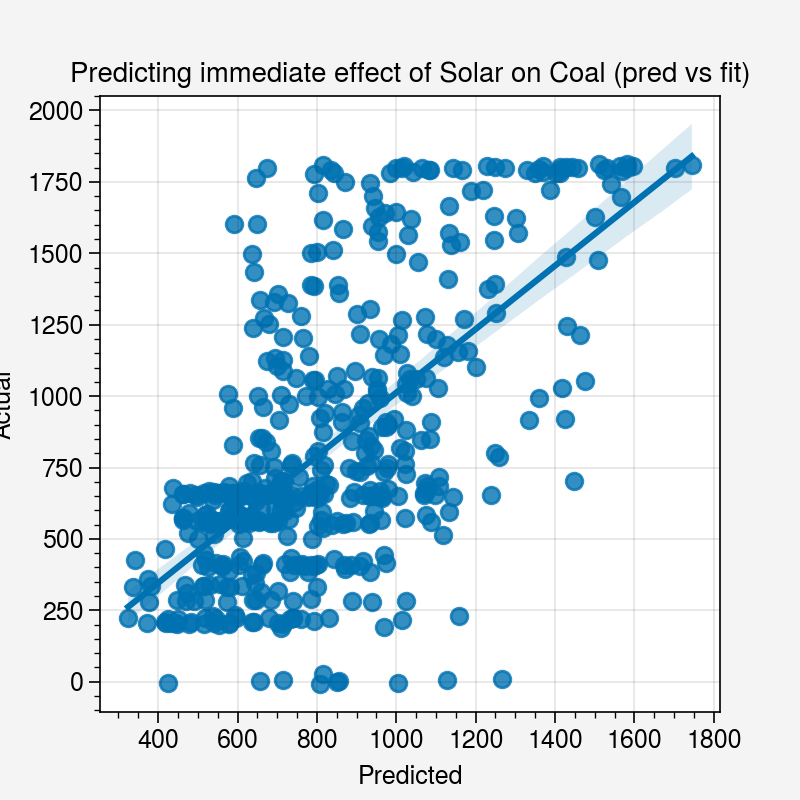

In [7]:
# run a regression using XGBoost sklearn wrapper
# default params for XGBRegressor
params = {
    'learning_rate': 0.1,
    'max_depth': 3,
    'n_estimators': 100
}
model = xgboost.XGBRegressor(**params)

W = pd.concat([A, X], axis=1)
model.fit(W, y)

# get the predictions
yhat = model.predict(W)

# plot predictions vs actual
idx = np.random.choice(range(len(y)), 500)
sns.regplot(x=yhat[idx], y=y.values[idx])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Predicting immediate effect of Solar on Coal (pred vs fit)")

Text(0.5, 1.0, 'Average effect of Solar on Coal in CAL')

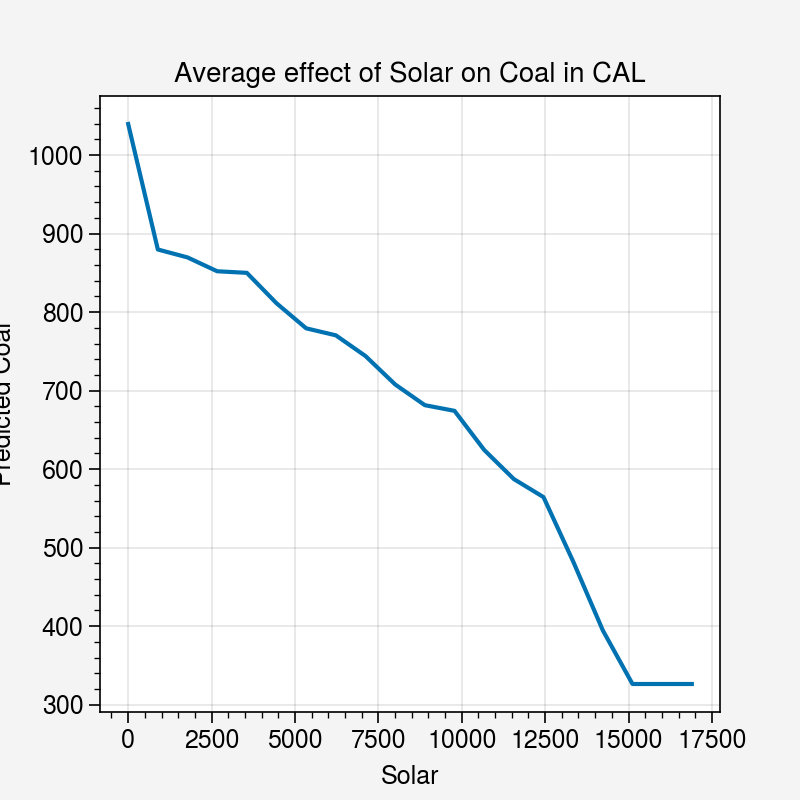

In [8]:

# make predictions for various values of A
agrid = np.linspace(amin, amax, 20)
preds = []
for a in agrid:
    W = pd.concat([pd.Series(a, index=X.index, name=A.name), X], axis=1)
    yhat_a = model.predict(W)
    preds.append(yhat_a)
preds = np.stack(preds, axis=1)
average_effect = preds.mean(0)

# make plot ofaverage effect using 
sns.lineplot(x=agrid, y=average_effect)
plt.xlabel("Solar")
plt.ylabel("Predicted Coal")
plt.title(f"Average effect of Solar on Coal in {region}")

# 3. All regions

In [30]:
# control all defaults here
predictors =  ["Sum (NG)", "Sum (Trade)"]
treatment = "NG: SUN"
outcome = "NG: COL"
params = {
    'learning_rate': 0.1,
    'max_depth': 3,
    'n_estimators': 100
}

def estimate_effect(region, predictors, treatment, outcome, params):
    file = f"data/energy/Region_{region}.parquet"
    df = pd.read_parquet(file)[predictors + [treatment] + [outcome]]
    df = df[df[treatment] > 0]
    df = df.dropna()
    if df.shape[0] == 0:
        return None, None
    X = df[predictors]
    A = df[treatment]
    y = df[outcome]
    amin, amax = A.min(), A.max()
    model = xgboost.XGBRegressor(**params)
    W = pd.concat([A, X], axis=1)
    model.fit(W, y)
    yhat = model.predict(W)
    agrid = np.linspace(amin, amax, 20)
    preds = []
    for a in agrid:
        W = pd.concat([pd.Series(a, index=X.index, name=A.name), X], axis=1)
        yhat_a = model.predict(W)
        preds.append(yhat_a)
    preds = np.stack(preds, axis=1)
    average_effect = preds.mean(0)
    return agrid, average_effect

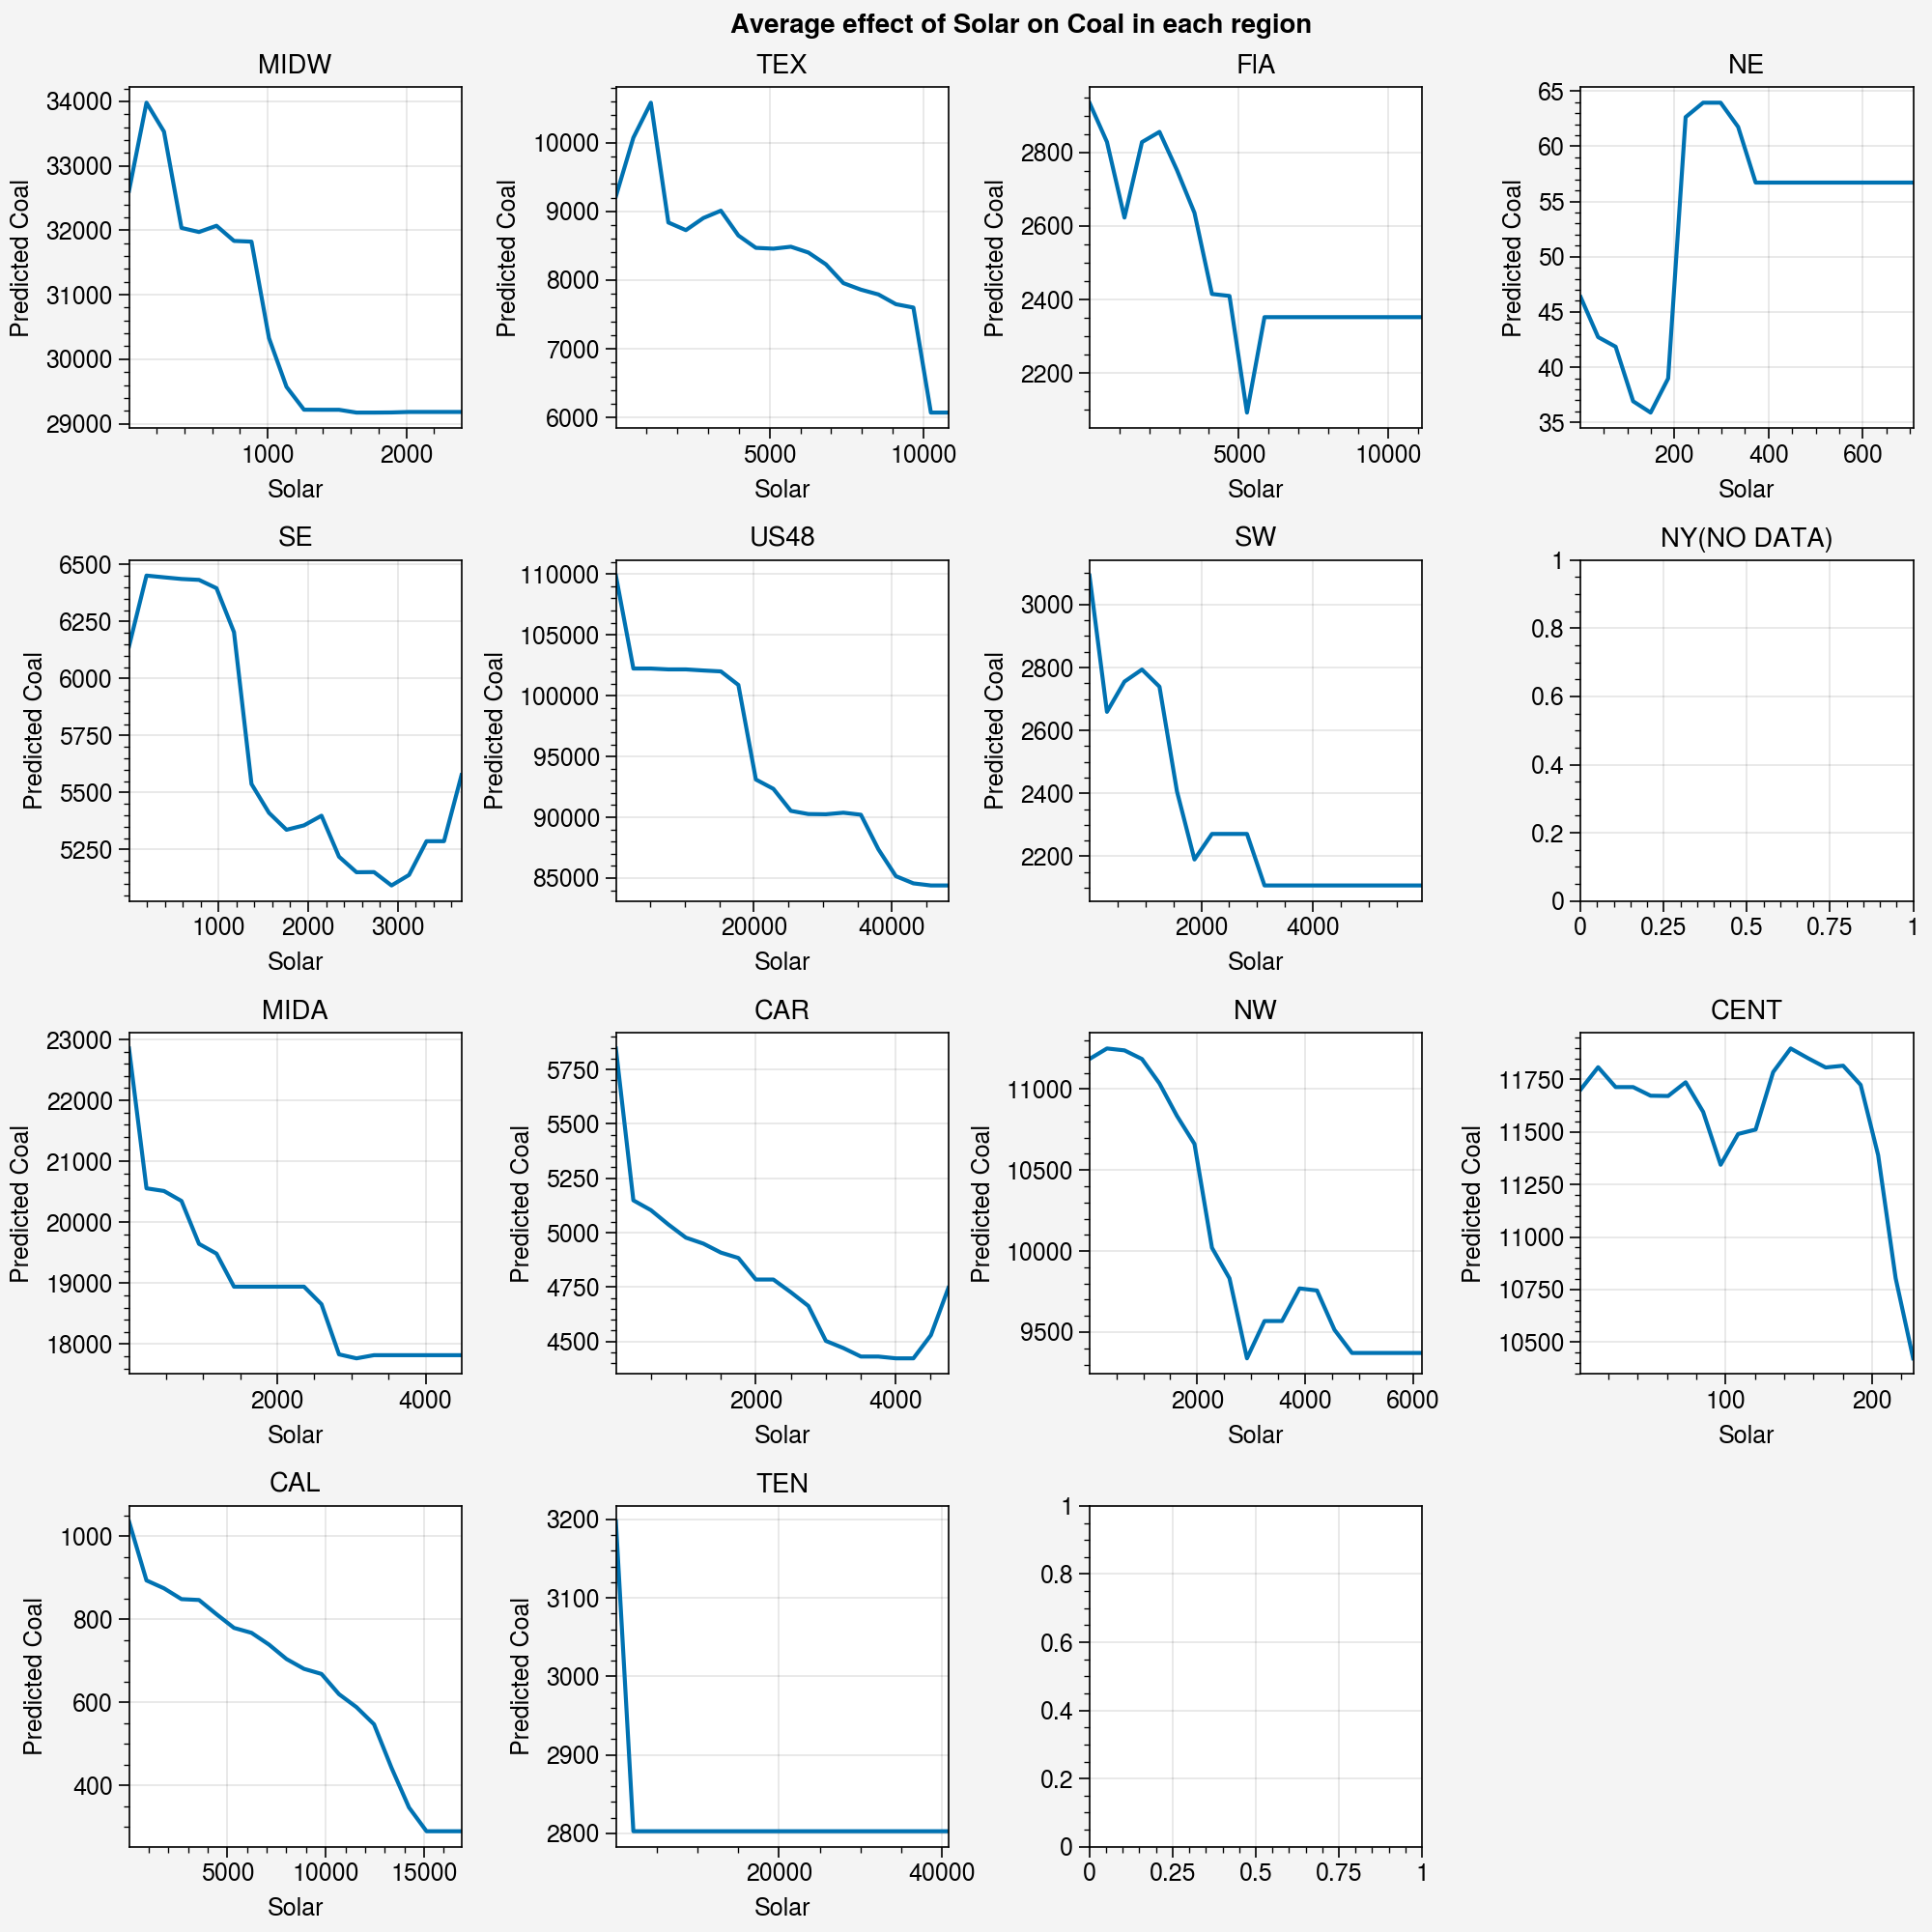

In [33]:
plot_grid = np.reshape(range(1, 17), (4, 4))
plot_grid[-1, -1] = 0

fig, ax = pplt.subplots(plot_grid, figsize=(10, 10), sharex=False, sharey=False)
for i, region in enumerate(regions):
    agrid, average_effect = estimate_effect(region, predictors, treatment, outcome, params)
    if average_effect is None:
        ax[i].format(title=region + "(NO DATA)")
        continue
    ax[i].plot(agrid, average_effect)
    ax[i].format(title=region)
    ax[i].format(xlabel="Solar")
    ax[i].format(ylabel="Predicted Coal")
fig.format(suptitle="Average effect of Solar on Coal in each region")